# MLS-- project
#### By Student:
#### Rita Valciukiene, No: G00376585


#### Instructions:

In this project you must create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle.
The goal: produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set.
I must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. 


I have to use few librarys ; for this project:

1. Jupyter notebook that trains a model using the data set. In the notebook you
should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.


To start my project I have to import librarys. 

In [1]:
import pandas as pd # Imported pandas for data frames.
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import math as m
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures # For generating polynomial features.
from sklearn.model_selection import train_test_split# Library for splitting data sets.
from sklearn.svm import SVR # Library for vector machine regression
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns

## Data set: Wind and Power representation

In [3]:
df = pd.read_csv("C:/Users/35385/Desktop/cmder/powerproduction.txt")

In [4]:
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [5]:
df.columns # The columns shows two column  names: Speed and power.

Index(['speed', 'power'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
speed    500 non-null float64
power    500 non-null float64
dtypes: float64(2)
memory usage: 7.9 KB


In [7]:
df.shape # The shape shows than in this dataset 502 rows and 2 columns.

(500, 2)

In [8]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


In [9]:
df.isin([0]).sum()

speed     1
power    49
dtype: int64

In [10]:

 # Sorted data by speed. Adapted code in source [2].
df.sort_values(by=['speed']).head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


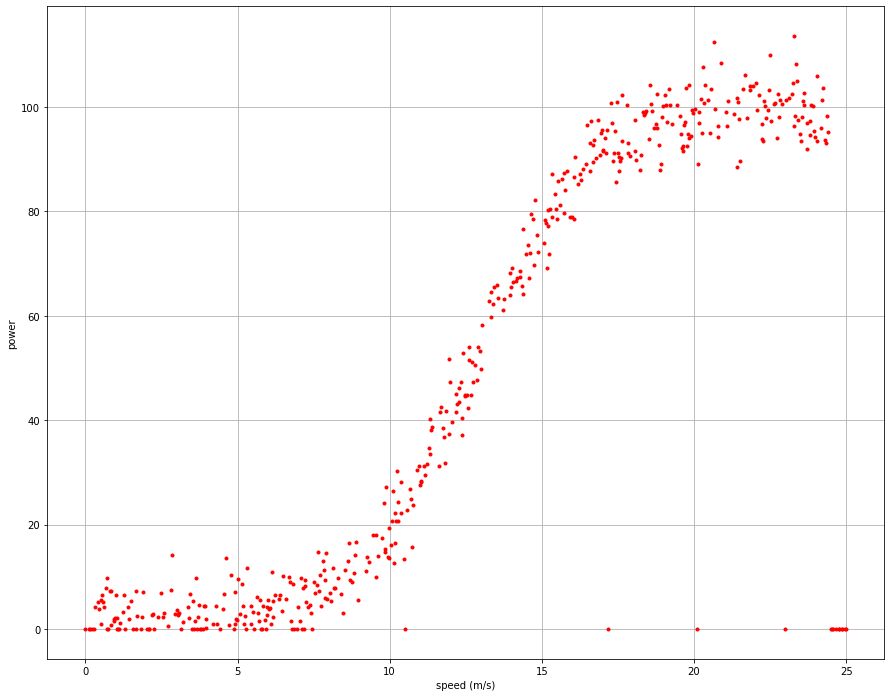

In [11]:
plt.figure(figsize=(15,12))
plt.plot(df['speed'], df['power'],  '.r') #  Plotted power of wind speed.
plt.xlabel('speed (m/s)', fontsize='10')
plt.ylabel('power', fontsize='10')
plt.grid()

The plot looks there is a range of wind speeds, where the power seems increase linearly with wind speed.  We need to adapt a model that works differently.

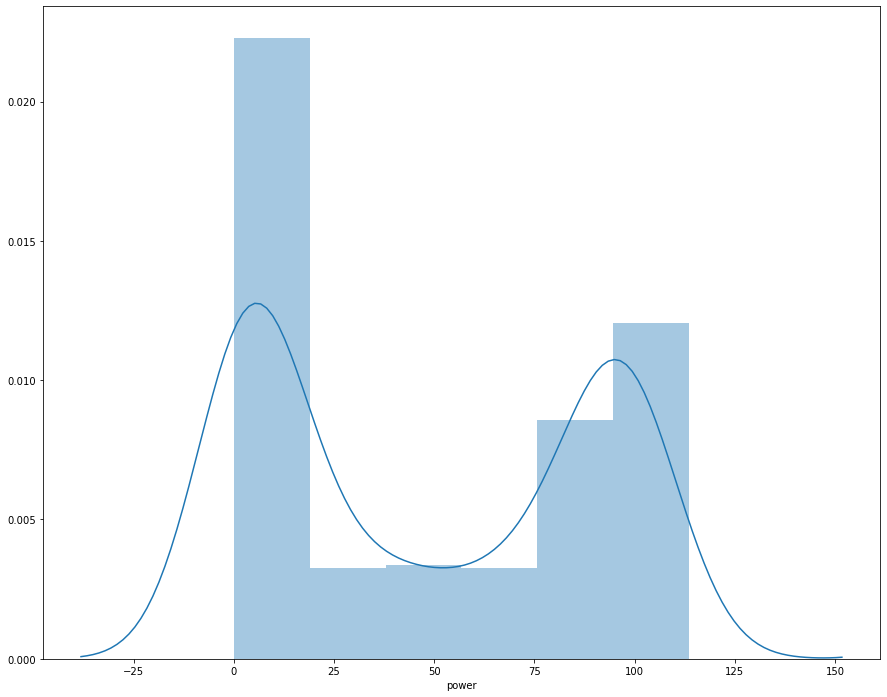

In [12]:
plt.figure(figsize=(15,12))
sns.distplot(df['power'])

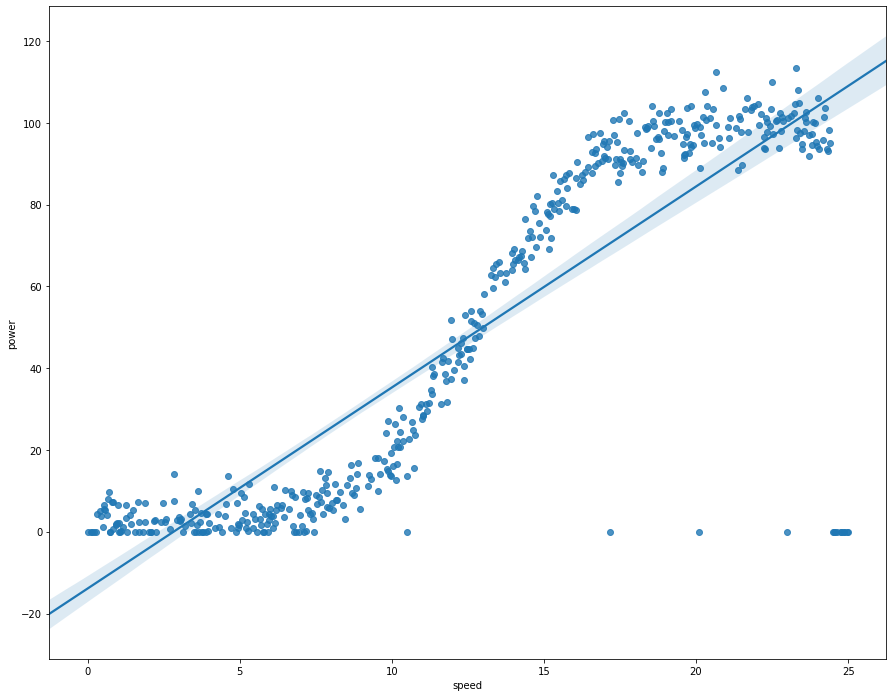

In [13]:
plt.figure(figsize=(15,12))
sns.regplot(x='speed',y='power',data = df)
plt.show()


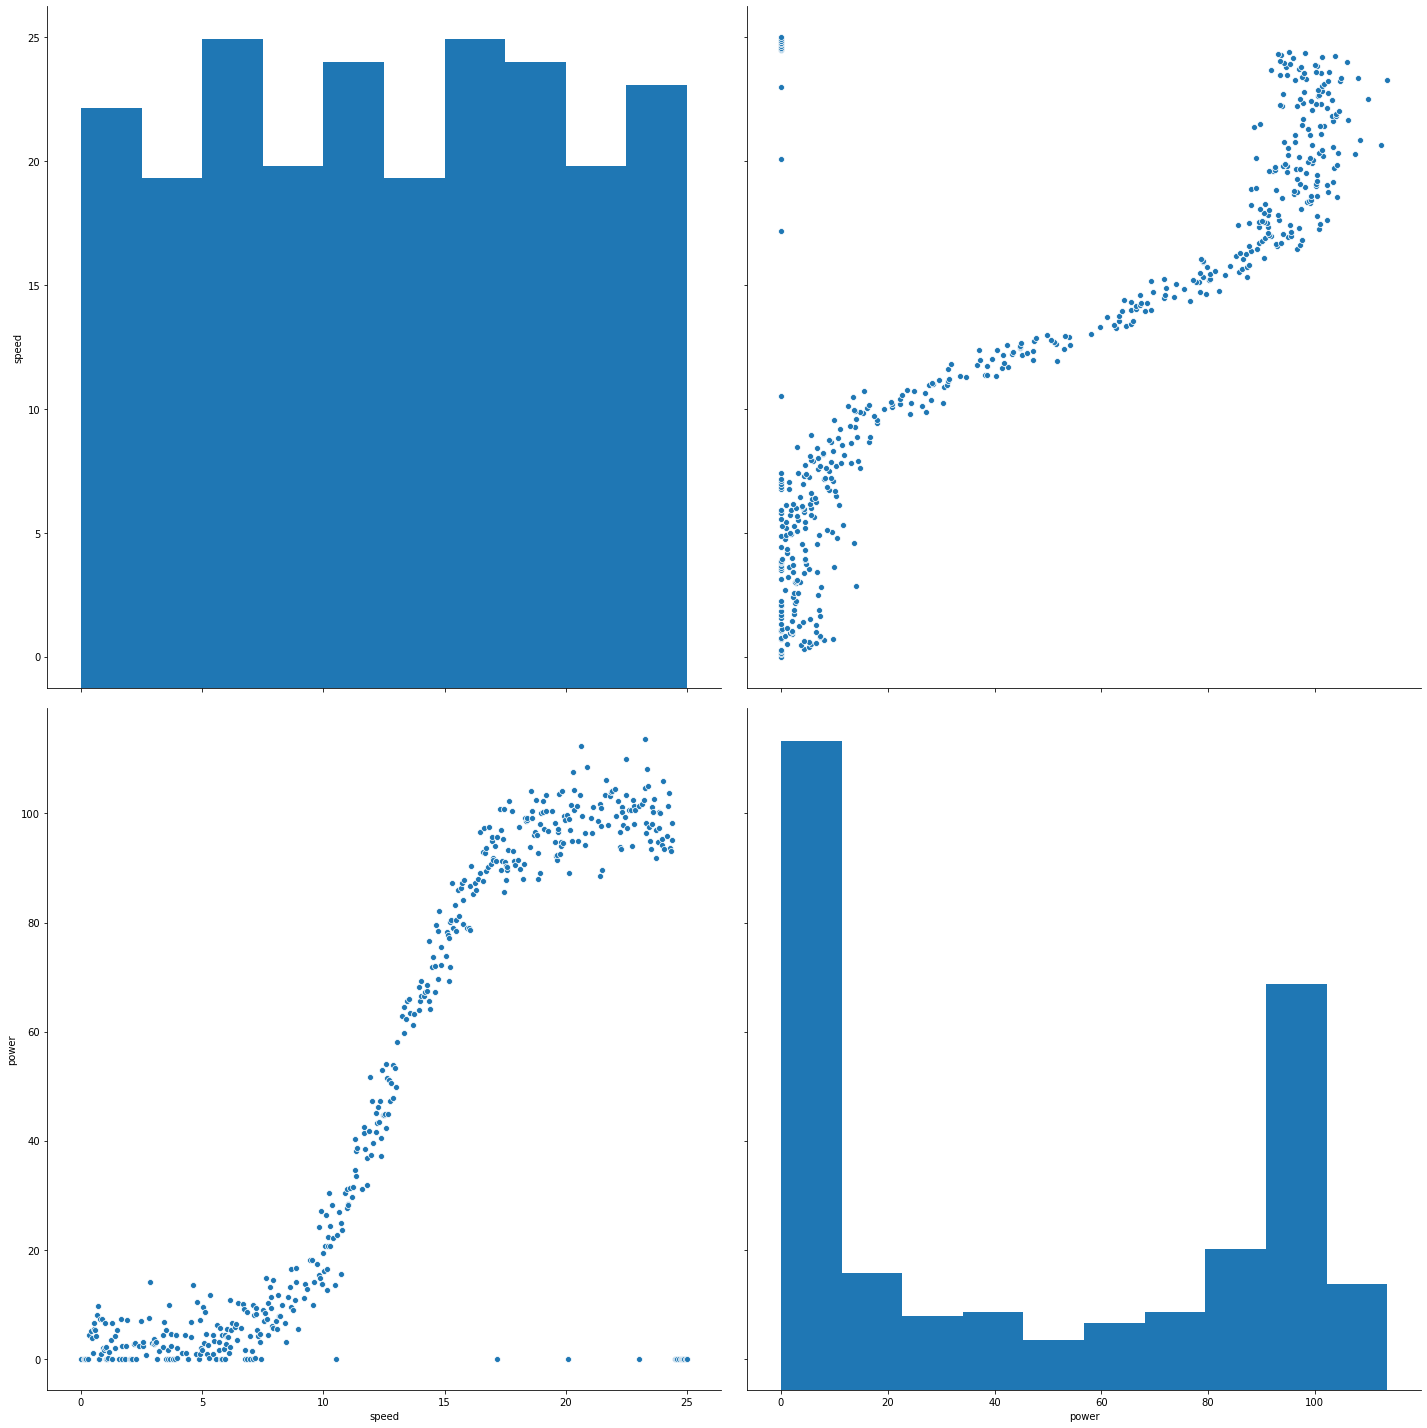

In [17]:
sns.pairplot(data = df, height=10)
plt.show()

 Wind speed looks uniformly distributed. And power have a number of zero values. From the scatter plot above we can see that we have values of power = 0 even with wind values higher than 3.25 $m/s$.Is it mean that the turbine has stopped. Next step what we will do,we should remove 0 values from the data set.

##### Noice
The data is affected by random noise. It is assumed thera are other factors in play which are not identified, and yet influence the reading. In research about wind turbines don't generate any output(power) untill it reaches all needed energy for customers. 

In [14]:
df[df.power==0].count() # Finded 0 values.

speed    49
power    49
dtype: int64

In [15]:
# Selected dataset from speed and power  0.
new_data = df[(df["speed"]==0) & (df["power"]==0)]
above_zero = df[(df["speed"]>0) & (df["power"]>0)] # Values > 0
new_data = new_data.append(above_zero)# Appended data

new_data

,speed,power
0,0.000,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


In [16]:
df_newd = df[df['power'] !=0] # Removed 0 values.

Text(0.5, 1.0, 'Wind Speed Removed 0 values in Power ) ')

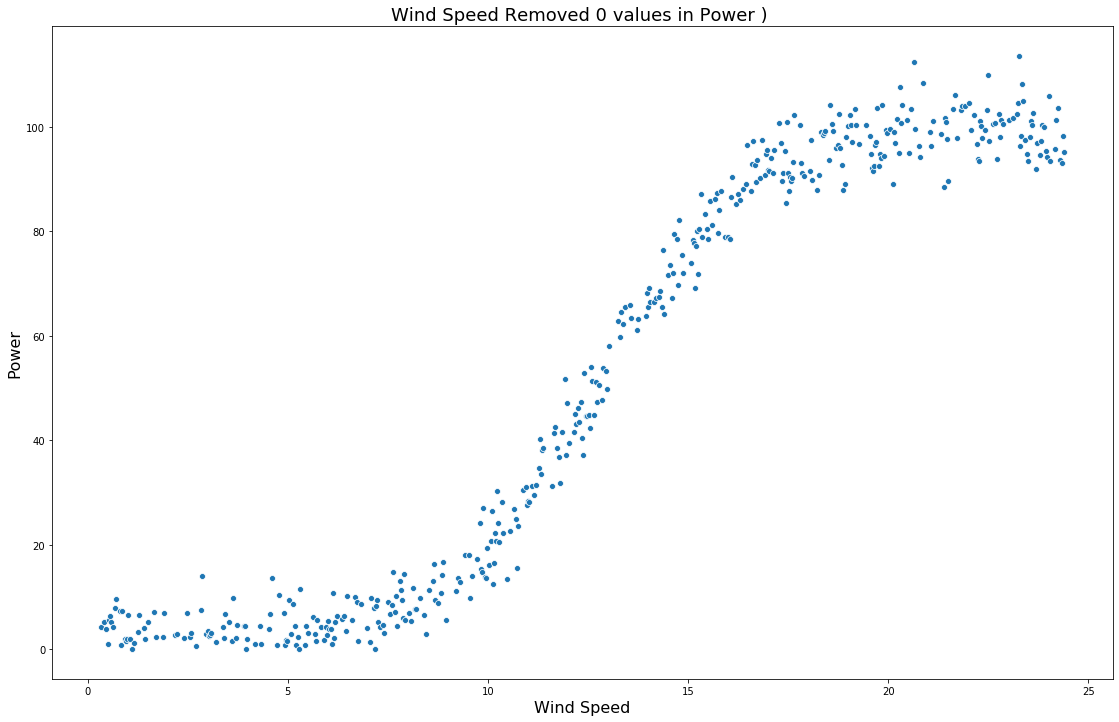

In [17]:
plt.figure(figsize=(19,12))
ax = sns.scatterplot(data=df_newd, x="speed", y="power")
ax.set_ylabel('Power', fontsize=16)
ax.set_xlabel('Wind Speed', fontsize=16)
ax.set_title("Wind Speed Removed 0 values in Power ) ",fontsize=18 )

###### In the theory, wind power turbines, the curve should look like in the graph below.

The speed at the start, typical value is around 3 m/s.
The rated output power is achieved at approximately 12 - 13 m/s.
The cut-out speed is the wind speed, where turbine will stop producing electricity (just for incase damage machine) around 25 m/s.


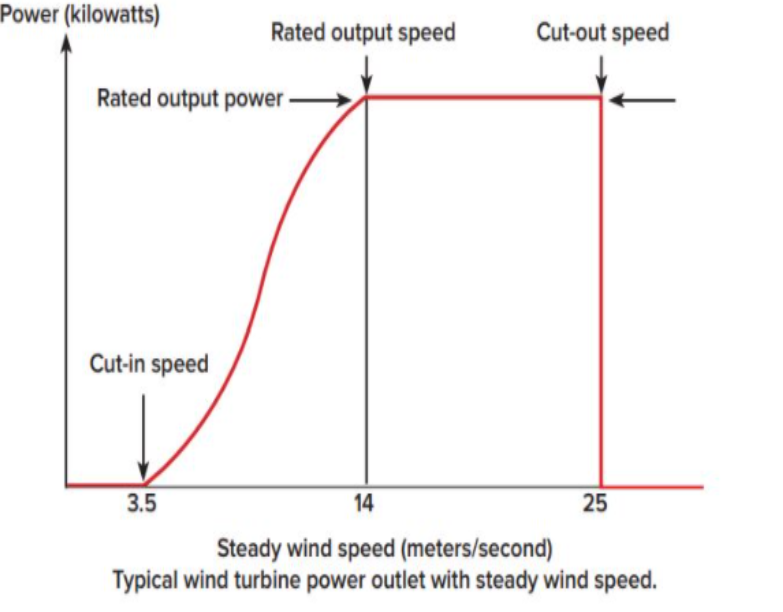

###### Linear Regression Model

What is Linear Regression Model?

Linear regression is commonly used type of predictive analysis. The idea of regression is to examine two things:

(1) does a set of predictor variables do a good job in predicting an outcome (dependent) variable?

(2) Which variables in particular are significant predictors of the outcome variable, and in what way do they–indicated by the magnitude and sign of the beta estimates–impact the outcome variable? 
These regression estimates explains the relationship between one dependent variable and one or more independent variables. 
The simplest form of the regression equation with one dependent and one independent variable is defined by the formula:
y = c + b*x, where y = estimated dependent variable score, c = constant, b = regression coefficient, and x = score on the independent variable.[1]

In our project we can use statistic librarys. So Python Scikit-Learn library for machine learning can be used to implement regression functions. It's could be coded by simple linear regression method code involving two variables.

In [4]:
import pandas as pd # The library for data frames.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from sklearn import linear_model # For linear regression.

In [20]:
import sklearn.linear_model as lin # Created linear regression correlation.
x = new_data["speed"].to_numpy()
y = new_data["power"].to_numpy()

x = x.reshape(-1, 1)

model = lin.LinearRegression()
model.fit(x, y)
r = model.score(x, y)
p = [model.intercept_, model.coef_[0]]

In [23]:

# Splitted data, converted to numpy arrays.
x = new_data['speed'].values.reshape(-1,1)
y = new_data['power'].values.reshape(-1,1)

# Splitted dataset into training. After I tested it.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

# Tested variable.
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(361, 1) (91, 1) (361, 1) (91, 1)


In [ ]:
linear_model = LinearRegression()

In [24]:
from sklearn.linear_model import LinearRegression # Imported LinearRegression from sklearn.
regression = LinearRegression()
regression.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
#Tried to make predictions.
lin_prediction = regression.predict(x)

# Printed Coefficients
print('Coeff.: \n', regression.coef_)

Coeff.: 
 [[5.54277422]]


In [26]:
lin_prediction = regression.predict(x_test)

In [27]:
# Tried to compare giving dataset for project with predicted data.
test = pd.DataFrame({'Real data': y_test.flatten(), 'Predicted data': lin_prediction.flatten()})
test

,Real data,Predicted data
0,91.270,75.840974
1,11.749,26.044690
2,9.034,22.580456
3,100.831,76.672390
4,7.060,8.152615
...,...,...
86,5.539,14.255209
87,43.454,49.069374
88,3.036,12.453808
89,2.030,3.020006


In [ ]:
# Plotted graph for linnear regression model.
plt.plot(df['speed'], df['power'], label="data set")
plt.plot(df['speed'], lin_prediction, 'k-')
plot.xlabel('speed(m/s)', fontsize='14')
plt.ylabel('power(kW)', fontsize='14')
plt.title("Linear- regression model")
plt.legend()

Text(0, 0.5, 'Power Output kW')

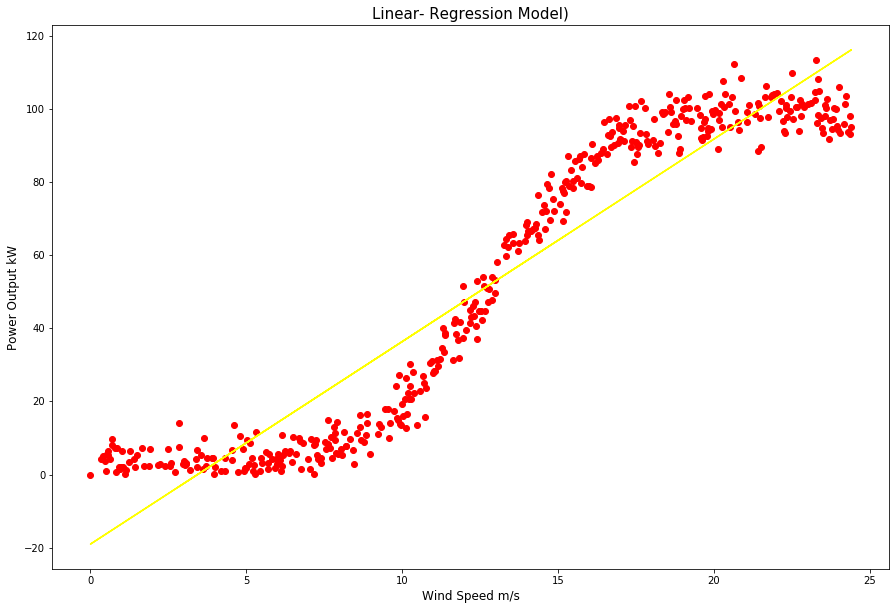

In [28]:
plt.figure(figsize=(15, 10))
plt.scatter(x, y, color='red', label='data')
plt.plot(x_train, regression.predict(x_train), color='yellow')
plt.title('Linear- Regression Model)',fontsize=15)
plt.xlabel('Wind Speed m/s',fontsize=12)
plt.ylabel('Power Output kW',fontsize=12)

This graph above is showing, that is not good enough. This is the model too simple to learn the structure of the dataset. So we will try another model a polynomial model.The accuracy for the given data set is resonable only in some limited ranges of wind speed.

######  Polynomial Regression Model 
In statistics, polynomial regression is a form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modelled as an nth degree polynomial in x.
 Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y, denoted E(y |x). Although polynomial regression fits a nonlinear model to the data, as a statistical estimation problem it is linear, in the sense that the regression function E(y | x) is linear in the unknown parameters that are estimated from the data. For this reason, polynomial regression is considered to be a special case of multiple linear regression.[3]
 The graph below, shows datasets plottung in the polynomial regression model.

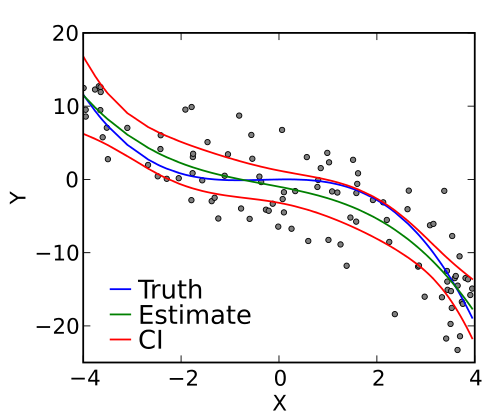

In [29]:
#For Polynomial Regression Model we need to import couple libraries.(Source[4])
# For linear regression.
from sklearn import linear_model
# For linear Regression
from sklearn.linear_model import LinearRegression

# For generating polynomial features in the data.
from sklearn.preprocessing import PolynomialFeatures

# For splitting data into train/test sets
from sklearn.model_selection import train_test_split

# For evaluating model.
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
# Polynomial Regression model code adapted from source(www.towardsdatascience.com)
poly_features = PolynomialFeatures(degree=3,include_bias=False)
x_train_poly = poly_features.fit_transform(x_train)

# Created the transformed features to Linear Regression model.
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)

# Next step, is to create a code for prediction.
poly_prediction = poly_model.predict(poly_features.fit_transform(x_test))



In [31]:
# Checked x_train_poly about really or not x, x^2, x^3.
print(x_train_poly[0])
print(x_train_poly[0][0]**2)
print(x_train_poly[0][0]**3)

[ 2.828       7.997584   22.61716755]
7.997584000000002
22.61716755200001


In [32]:
regressionPred = linear_model.LinearRegression()
regressionPred.fit(x_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

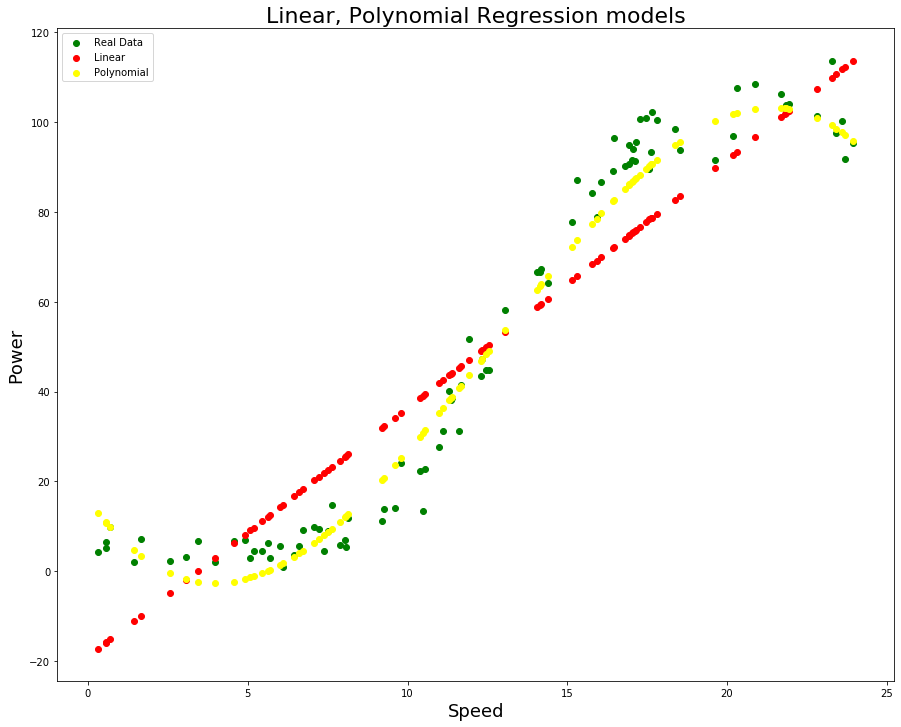

In [33]:
plt.figure(figsize=(15,12))
x_grid = np.arange(min(x), max(x), 0.2)
x_grid = x_grid.reshape((len(x_grid), 1))
plt.scatter(x_test, y_test, color = 'green')
plt.scatter(x_test, lin_prediction, color = 'red')
plt.scatter(x_test, poly_prediction, color = 'yellow')
plt.title('Linear, Polynomial Regression models', fontsize=22)
plt.xlabel('Speed', fontsize=18)
plt.ylabel('Power', fontsize=18)
labels = ("Real Data", "Linear", "Polynomial")

plt.legend(labels)
plt.show()

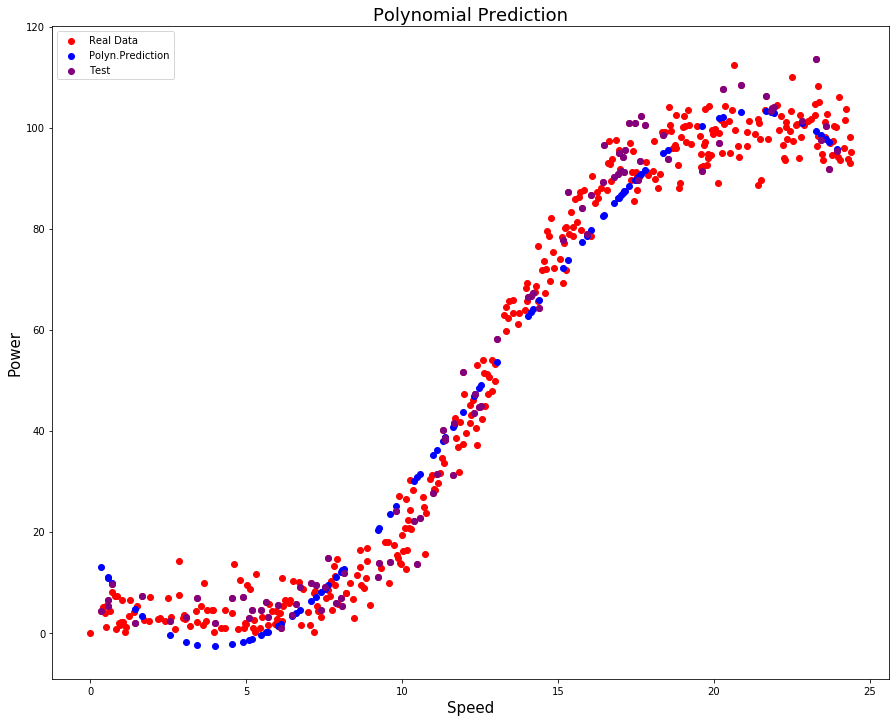

In [34]:
import numpy as np
plt.figure(figsize=(15,12))
plt.scatter(x, y, color = 'red')
plt.scatter(x_test, poly_prediction, color = 'blue')
plt.scatter(x_test, y_test, color = 'purple')
plt.title('Polynomial Prediction', fontsize=18)
plt.xlabel('Speed', fontsize=15)
plt.ylabel('Power', fontsize=15)
labels = ("Real Data", "Polyn.Prediction", "Test")

plt.legend(labels)
plt.show()

Polynomial regression model is reasonably good for predicting power given wind speed.Polynomial regression offers the possibility of increasing almost good the model fittnes to the train data points in the data set. The higher the polynomial order, the more closely the curve fits. 

#### Neural Network

##### What is a neural network?

The basic idea behind a neural network is to simulate (copy in a simplified but reasonably faithful way) lots of densely interconnected brain cells inside a computer so you can get it to learn things, recognize patterns, and make decisions in a humanlike way.[7].

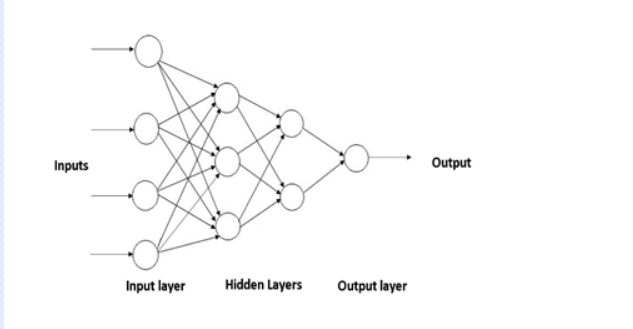

###### What is KERAS?
Keras is a neural network library while TensorFlow is the open-source library for a number of various tasks in machine learning. TensorFlow provides both high-level and low-level APIs while Keras provides only high-level APIs. Both frameworks thus provide high-level APIs for building and training models with ease.[6].

We can specify the number of neurons or nodes in the layer as the first argument, and specify the activation function using the activation argument.

A “neuron” in a neural network is a mathematical function that collects and classifies information according to a specific architecture. The network bears a strong resemblance to statistical methods such as curve fitting and regression analysis. A neural network contains layers of interconnected nodes.[9].

In [ ]:
# For neural networks
import tensorflow.keras as kr

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
data = df


model = kr.models.Sequential()
# Added 1st hidden layer
model.add(kr.layers.Dense(50, input_shape=(1,), activation="sigmoid", kernel_initializer="glorot_uniform"))
# 2nd hidden
model.add(kr.layers.Dense(40, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# 3rd hidden
model.add(kr.layers.Dense(20, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Outp. layer
model.add(kr.layers.Dense(1, activation="linear", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

In [ ]:
# I had to compile the model and summarize it.
model.compile(kr.optimizers.Adam(lr=0.001), loss="meaning_sqr_error")
model.summary()


##### Conclusions

The aim of the projec-  to analyze the data from the powerproduction.csv file, to create and test a model for prediction the power of the wind turbine. I started by loading the data into the dataframe. Checking the null values and removing the zero power values. To train the models, the data was divided into training set date and test set date. Two models have been trained:

I tested the linear regression model and test was not too good. Although it is clear from the graph that our fit line aquraccy about 89%. 
    With Polynomial regression - the obtained result for the training and test sets is better than with linear regression, aquracy about 93%.



Neural Network looked like is well suited for power curve modelling, and shoved us that neurons were able to reduce the level of both the absolute and random error.

### References
[1] https://www.statisticssolutions.com. what-is-linear-regression.

[1]. www.w3schools.com. Linear Regression Model.

[2].https://pandas.pydata.org .DataFrame.sort values.

[3].https://en.wikipedia.org/wiki. Polynomial_regression.

[4].https://towardsdatascience.com. Machine-learning-polynomial-regression-with-python.

[5].https://scikit-learn.org. Stablemodules-generated-sklearn.preprocessing.PolynomialFeatures.

[6].www.overflow.org. What is Keras.

[7].https://www.explainthatstuff.com. Introduction-to-neural-networks.

[8]. https://www.investopedia.com. Neuralnetwork explanation.


